# Example Analysis of historical data and predictions

This notebook analyzes how well the <b>DSF prediction model</b> estimates the number of trades that occur between strategy resets, by comparing:

- Actual historical trading data from strategy CSVs
- Model predictions using pool data within specific dates in template_dsf_model.xlsx 

The notebook:
- Imports actual historical trading data (single/multiple)
- Imports pool trading data and creates separate copies filtered by trading dates for each strategy
- Fills out the template_dsf_model.xlsx file with the filtered pool data
- Imports prediction data from the specific sheet according to mean/median trading frequency of the strategy
- Performs statistical comparison of prediction vs actual results
- Performs statistical hypothesis testing
- Measures prediction error
- Visualizes prediction vs actual results

<b>1. Import required for the analysis libraries and files

In [1]:
import os
import sys
sys.path.append("../analysis")
sys.path.append("../utils")


import pandas as pd
from IPython.display import display, Markdown

from data_import import read_dex_data, read_raindex_data, read_model_predictions  
import evaluation as ev
import visualization as vis
import utils

<b>2. Import historical raindex data. </b>

At this step user needs to enter all the names of the actual strategy data (.csv files) into 'strategy_filenames' list.<br>
<i>(Example: strategy_filenames = ['strategy_1_file_name.csv', 'strategy_2_file_name.csv'])</i><br><br>
The files are imported, cleaned and processed to be used in the upcoming analysis. Such fields as 'reset' and 'trade_count' are added.

In [2]:
# Names of the csv files with historical strategy data
# Add all the file names that contain strategy historical data 
strategy_filenames = ['base-0x0e2a8c94fc7fd892abe7d7cfa0c7baae39eba83c04c4d6cc2410bb2e4bc44972.csv'
                        ,'base-0x5aa490f9ce3167fba059a7a3707bdbbb1d3bebae45e58b50f6add63123e95b5b.csv'
                        ,'base-0x6579cf51a7cb1bb7d4c5bc046c3807533fe1401f1af8d43076f19196cd73fa21.csv'
                        ,'base-0x77b971ba727992deff71b24b9a2e0363e61f20d7bef8d0fd64164d3cec3b8edf.csv'
                        ,'base-0x858bc93684aa375c1d02a5b09d72f913c6239d6916abeb26b88ebc91679ec9b6.csv'
                        ,'base-0x943493dae1cf0dc6882b4b48dada7bbba87d66aeffc08b996f16fe7fe2a761f2.csv'
                        ,'base-0xbc1f0c7e6d01d6fc69aa14c45255bbe1e290907fa0b695b8c7c707b8798c474b.csv'
                        ,'base-0xbdffe74d38286fe9182c52e79161ed9d87e71a5133c34c069b2e3e541a74f9df.csv'
                        ,'base-0xc1b5442dda956380adf3a9f13a9ee9bea017ef2c94b28f6b11f3c22bb4e8b3bb.csv']
# Read the csv and process dataframe accordingly
strat_dfs = [read_raindex_data(csv_path=utils.get_data_path(strat_name, 'trade')) for strat_name in strategy_filenames]
# Add column with time window between consecutive transactions in mins
for index in range(len(strat_dfs)):
    strat_dfs[index] = utils.add_timestamp_diffs(strat_dfs[index])
    utils.add_reset_trade_count(strat_dfs[index])       
    strat_dfs[index]['trade_count_mod'] = strat_dfs[index]['recent_reset_mod'] - strat_dfs[index]['last_reset_mod']

Next, total number of entries and start/end dates of the trading period for each strategy is printed for reference.

In [3]:
for index, df in enumerate(strat_dfs):
    print('The strategy {} dataframe contains total of {} entries from {} to {} || file: {}'.format(index+1, len(df), df['timestamp_date'].min(), df['timestamp_date'].max(), strategy_filenames[index]))

The strategy 1 dataframe contains total of 70 entries from 2024-11-14 11:36:25 to 2024-12-26 17:13:59 || file: base-0x0e2a8c94fc7fd892abe7d7cfa0c7baae39eba83c04c4d6cc2410bb2e4bc44972.csv
The strategy 2 dataframe contains total of 228 entries from 2025-03-05 20:43:53 to 2025-04-04 16:19:53 || file: base-0x5aa490f9ce3167fba059a7a3707bdbbb1d3bebae45e58b50f6add63123e95b5b.csv
The strategy 3 dataframe contains total of 306 entries from 2024-10-31 15:30:29 to 2024-11-17 13:10:29 || file: base-0x6579cf51a7cb1bb7d4c5bc046c3807533fe1401f1af8d43076f19196cd73fa21.csv
The strategy 4 dataframe contains total of 268 entries from 2025-01-31 14:14:19 to 2025-02-16 12:20:27 || file: base-0x77b971ba727992deff71b24b9a2e0363e61f20d7bef8d0fd64164d3cec3b8edf.csv
The strategy 5 dataframe contains total of 151 entries from 2024-11-06 18:34:43 to 2024-12-18 17:34:35 || file: base-0x858bc93684aa375c1d02a5b09d72f913c6239d6916abeb26b88ebc91679ec9b6.csv
The strategy 6 dataframe contains total of 276 entries from 2

<b>3. Statistical metrics for each strategy are measured.</b><br>
Statistical metrics for trading frequency (time between consecutive transactions in minutes) are found and combined in a single matrix. Each column here represents single strategy, while rows represent various statistical measures. The last two columns show mean and standard deviation for each row (metric). 

In [4]:
# Calculate trade frequency statistics
trade_stats = []
for df in strat_dfs:
    trade_stats.append(ev.describe_distribution(df['time_diff_min'], skip_first_in_min=True))

strategy_stats_df = pd.DataFrame(trade_stats)
mean = [strategy_stats_df[col].mean() for col in strategy_stats_df.columns]
std = [strategy_stats_df[col].std() for col in strategy_stats_df.columns]
strategy_stats_df = strategy_stats_df.T
strategy_stats_df.columns = ['Strategy {}'.format(i+1) for i in range(len(strat_dfs))]
strategy_stats_df['Mean'] = mean
strategy_stats_df['Std'] = std

display(Markdown("**Values here are for trading frequency in minutes.**"))
display(strategy_stats_df)

**Values here are for trading frequency in minutes.**

,Strategy 1,Strategy 2,Strategy 3,Strategy 4,Strategy 5,Strategy 6,Strategy 7,Strategy 8,Strategy 9,Mean,Std
mean,868.371429,187.837719,79.065359,85.089552,399.649007,80.152174,91.778169,79.148997,212.990698,231.564789,261.352200
median,164.000000,68.500000,7.000000,49.500000,63.000000,11.000000,21.500000,35.000000,57.000000,52.944444,47.283351
std,2177.010396,422.833337,760.979211,238.515099,2570.594961,595.227735,280.569430,328.357757,920.732256,921.646687,859.199336
cv,2.507004,2.251057,9.624685,2.803107,6.432131,7.426221,3.057039,4.148603,4.322875,4.730302,2.555073
mad,80.000000,38.000000,7.000000,33.500000,33.000000,11.000000,21.500000,32.000000,40.000000,32.888889,21.143524
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10854.000000,3269.000000,13162.000000,3537.000000,29002.000000,9776.000000,3492.000000,5715.000000,8499.000000,9700.666667,8070.721436
iqr,246.500000,87.250000,30.000000,65.250000,65.500000,29.000000,84.250000,70.000000,82.500000,84.472222,64.466979
skew,3.189937,4.560945,16.724595,11.792886,9.939540,15.766148,8.353743,15.144613,7.439768,10.323575,4.904548
kurtosis,9.083934,23.403386,284.438500,163.235183,103.318582,253.975203,85.258805,250.449721,57.361322,136.724960,105.119201


<b>Visualize time between transactions for to find trends, outliers, distribution characteristics. </b>

**Displays histograms of the time between transactions of each strategy in a grid.**

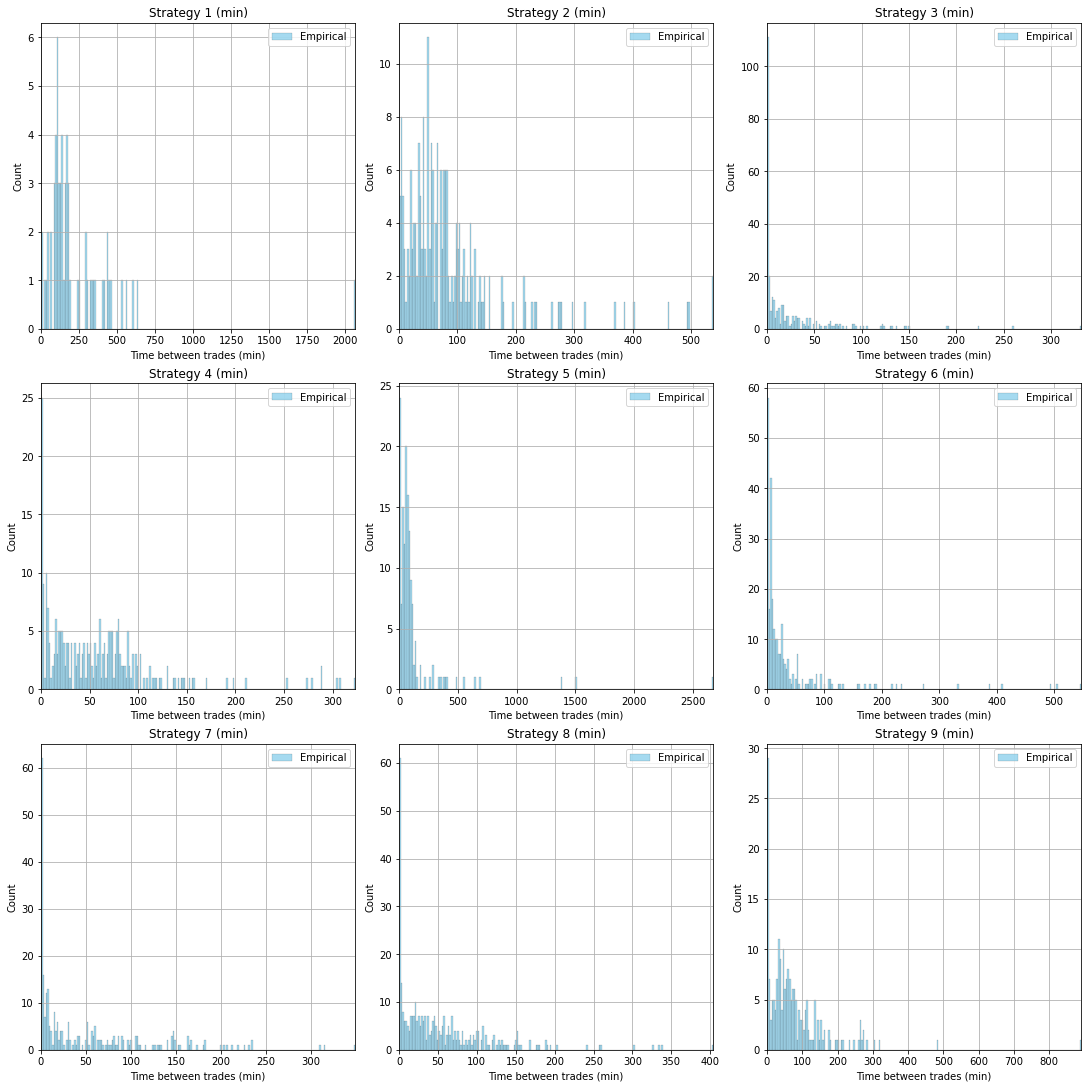

In [5]:
display(Markdown("**Displays histograms of the time between transactions of each strategy in a grid.**"))
vis.plot_trade_time_hist_grid(strat_dfs, time_unit = 'min', bins = 200, kde = False,  fig_size = (15,15), fit_exp = False)

If user required further inspection of any specific strategy results, 'strategy_num' should be set to the strategy to display. <i>(e.g. strategy_num=1)

**Displays the histogram of the time between transactions of strategy 1.**

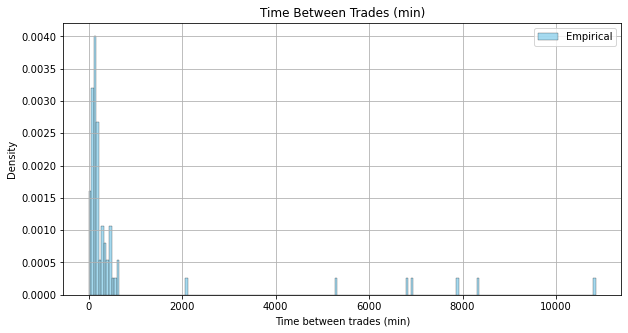

In [6]:
# Choose the number of strategy to get expanded histogram
strategy_num = 1
# Plot histogram of the transaction frequencies in specific strategy.
# Skip first row 
chosen_strategy_df = strat_dfs[strategy_num-1]
display(Markdown(f'**Displays the histogram of the time between transactions of strategy {strategy_num}.**'))
vis.plot_trade_time_hist(chosen_strategy_df[1:], time_unit = 'min', bins = 200, kde = False, fit_exp=False)

<b>4. Import pool data and filter transactions to match strategy trading time window.</b><br>

At this step user needs to enter the name of the pool data (.csv files) into 'pool_filename'.<br>
<i>(Example: pool_filename = 'pool_file_name.csv')</i><br><br>
<b>This file should contain pool trading data that includes transactions for the time period containig all periods of strategy files entered above to match properly.</b>  
The file is imported, cleaned and processed to be used in the upcoming analysis.

In [7]:
# Name of the csv file with historical pool data
pool_filename = 'wlth-usdc-pool-0x1536ee1506e24e5a36be99c73136cd82907a902e.csv'
# Read the csv and process dataframe accordingly
pool_df = read_dex_data(csv_path=utils.get_data_path(pool_filename, 'trade'))

In [8]:
display(Markdown(f'**Show the number of entries in the pool data and start/end dates. Display top 5 rows of the dataframe.**'))
# Display the first few rows and show number of transactions with respective operation time window
ev.display_df_info(pool_df, 'timestamp_date')

**Show the number of entries in the pool data and start/end dates. Display top 5 rows of the dataframe.**

The dataframe contains total of 109171 entries from 2024-05-30 12:09:07 to 2025-04-14 09:37:53


,block_number,tx_hash,token_amount_a,token_amount_b,timestamp_int,token_price_a,abs_token_b_amount,timestamp_date,timestamp_floored,tx_group
0,15140800,0x5db47d125163117c812264d69b2114da13caf87fa66b...,50000.000000,210343.464656,1717070947,4.206869,210343.464656,2024-05-30 12:09:07,2024-05-30 12:00:00,1
1,15140800,0x2f0a70f9a559ae9f4a91ed920da86a307b0731a8d99e...,369.351786,2041.861601,1717070947,5.528230,2041.861601,2024-05-30 12:09:07,2024-05-30 12:00:00,1
2,15140800,0xb413cecefe67dfa4deacac13befc2afd0c243782e235...,147.666205,814.234289,1717070947,5.514019,814.234289,2024-05-30 12:09:07,2024-05-30 12:00:00,1
3,15140800,0x4bba7f8f7cf15cc8fb23eec97c2ff857e6f4d6765cba...,361.747242,1893.557563,1717070947,5.234477,1893.557563,2024-05-30 12:09:07,2024-05-30 12:00:00,1
4,15140800,0x41d9755bcf2772094a5f31198657cf0885bdbe39eb91...,367.354343,1999.877908,1717070947,5.444002,1999.877908,2024-05-30 12:09:07,2024-05-30 12:00:00,1


In [9]:
# Check that real trading data is within pool time bounds
min_pool_date = pool_df['timestamp_date'].min()
max_pool_date = pool_df['timestamp_date'].max()
for i, df in enumerate(strat_dfs):
    strat_min_date = df['timestamp_date'].min()
    if strat_min_date < min_pool_date:
        print('Strategy #{} earliest transaction date ({}) is outside of pool data time window (starts: {})\n'.format(i+1,
                                                                                                             strat_min_date,
                                                                                                            min_pool_date))
    strat_max_date = df['timestamp_date'].max()
    if strat_max_date > max_pool_date:
        print('Strategy #{} latest transaction date ({}) is outside of pool data time window (ends: {})\n'.format(i+1,
                                                                                                             strat_max_date,
                                                                                                            max_pool_date))

If anything gets printed above, this means that strategy data is out of bounds of dates from pool data.  

<b>5. Filter pool data and extract transactions for the same time period as each strategy.</b><br>

In this part the pool data is filtered to match the time period of each strategy and the resulting dataset is written into a .csv file.  <br>
<i>The format for the name of a new file is 'matched_strat-{strategy_file_name_here}_pool-{pool_file_name_here}.csv'</i><br><br>
<b>The filtered pool data for each strategy is written in the 'Data' sheet of a template model spreadsheet file. User needs to make sure the fields in the model sheets are updated before proceeding.</b><br>
<i>The format for the name of a new model spreadsheet is 'predictions-{strategy_file_name_here}_pool-{pool_file_name_here}.xlsx'</i><br>

In [10]:
# Filter transactions by raindex trading time window 
pool_filename_wo_ext = utils.remove_extension(pool_filename)
strategy_filenames_wo_ext = [utils.remove_extension(strat_name) for strat_name in strategy_filenames]
prediction_filenames = []
write_files = True
for i, df in enumerate(strat_dfs):
    matched_pool_df = utils.filter_by_timestamp_range(df, pool_df, 'timestamp_date', 'timestamp_date')
    # Write into csv file to be used in the model spreadsheet
    matched_csv_name = 'matched_strat-{}_pool-{}.csv'.format(strategy_filenames_wo_ext[i], pool_filename_wo_ext)
    if write_files:
        matched_pool_df.to_csv(utils.get_data_path(matched_csv_name, 'trade'), index=False)
    # These transactions need to be used in the model to compare predictions vs actual
    # Create a copy of model template and write filtered data into model file
    model_name = 'predictions-strat_{}_pool-{}.xlsx'.format(strategy_filenames_wo_ext[i], pool_filename_wo_ext)
    if write_files:
        utils.fill_template_with_data(matched_pool_df, model_name)
    prediction_filenames.append(model_name)

<b>6. Load predictions from the model using the filtered data from above.</b><br>


In [11]:
# Names of the spreadsheet model files that use historical pool data filtered by date in above steps
# Add all the file names that contain model data
# prediction_filenames = [] # Uncomment and edit this line if file names need to be changed from automatically assigned values
# If do not need to compare, write an empty string '' in the place of strategy model name
# The number and order of entries needs to be matched to the strategy names provided in the beginning of this analysis   
strat_frequencies = strategy_stats_df.loc['mean':'median'].copy()
strat_frequencies = strat_frequencies[strat_frequencies.columns[:-2]]

display(Markdown(f'**Show the mean and median time between transactions in minutes for reference.**'))
print('Mean and median trading frequency of explored strategies:')
display(strat_frequencies)

**Show the mean and median time between transactions in minutes for reference.**

Mean and median trading frequency of explored strategies:


,Strategy 1,Strategy 2,Strategy 3,Strategy 4,Strategy 5,Strategy 6,Strategy 7,Strategy 8,Strategy 9
mean,868.371429,187.837719,79.065359,85.089552,399.649007,80.152174,91.778169,79.148997,212.990698
median,164.000000,68.500000,7.000000,49.500000,63.000000,11.000000,21.500000,35.000000,57.000000


<b> Find the closest sheet in the model spreadsheet that matches the mean/median time between transactions. </b>
<br>If the time of strategy data is more than the chosen threshold, then the strategy will not be considered for the comparison. 
<br><i> Set 'time_threshold' to the maximum time spread between transactions. (e.g. time_threshold = 120)</i>

In [12]:
median_freq_sheet_name = []
mean_freq_sheet_name = []
time_threshold = 120
for col in strat_frequencies.columns:
    if strat_frequencies.loc['mean', col] <= time_threshold:
        mean_freq_sheet_name.append(utils.get_closest_sheet_name(strat_frequencies.loc['mean', col]))
    else:
        mean_freq_sheet_name.append('')
        
    if strat_frequencies.loc['median', col] <= time_threshold:
        median_freq_sheet_name.append(utils.get_closest_sheet_name(strat_frequencies.loc['median', col]))
    else:
        median_freq_sheet_name.append('')

display(Markdown('**Print the chosen model sheet for each strategy using mean/median.**'))
display(Markdown('*If strategy mean/median is above time_threshold, then empty sheet is chosen (no comparison).*'))
print('Mean model sheets:')
print(mean_freq_sheet_name)
print('Median model sheets:')
print(median_freq_sheet_name)

**Print the chosen model sheet for each strategy using mean/median.**

*If strategy mean/median is above time_threshold, then empty sheet is chosen (no comparison).*

Mean model sheets:
['', '', '90M', '90M', '', '90M', '90M', '90M', '']
Median model sheets:
['', '60M', '15M', '60M', '60M', '15M', '15M', '30M', '60M']


<b>Import model prediction from the chosen time sheet for each strategy.</b>
<br>Both mean and median prediction sheets are chosen separately for further analysis.

In [13]:
prediction_mean_dfs = [] 
prediction_median_dfs = [] 
# Read data from the model into dataframe
for i, file_name in enumerate(prediction_filenames):
    pool_mean_pred_df = None
    if mean_freq_sheet_name[i] != '':
        pool_mean_pred_df = read_model_predictions(file_path=utils.get_data_path(file_name, 'model'), sheet_name=mean_freq_sheet_name[i])
        # Calculate trade counts from resets
        utils.add_reset_trade_count(pool_mean_pred_df)        
    pool_median_pred_df = None
    if median_freq_sheet_name[i] != '':
        pool_median_pred_df = read_model_predictions(file_path=utils.get_data_path(file_name, 'model'), sheet_name=median_freq_sheet_name[i])
        # Calculate trade counts from resets
        utils.add_reset_trade_count(pool_median_pred_df)        
    prediction_mean_dfs.append(pool_mean_pred_df)
    prediction_median_dfs.append(pool_median_pred_df)

Some useful functions for data comparison.

In [14]:
def evaluate_hypothesis_test(index, actual_series, predicted_series, label, alpha=0.05):
    """Perform statistical hypothesis tests (t-test and Mann–Whitney U test)
        and format the result for a specific strategy and prediction label."""
    """Parameters:
        index (int): Index of the strategy.
        actual_series (pd.Series): actual trade count values.
        predicted_series (pd.Series): predicted trade count values.
        label (str): 'mean' or 'median' to identify test type.
        alpha (float): significance level for the tests."""
    """Returns:(pd.DataFrame): dataframe with p-values and significance flags."""
    hypothesis_eval = ev.perform_hypothesis_tests(actual_series, predicted_series, alpha=alpha)
    return pd.DataFrame.from_dict(hypothesis_eval, orient='index', columns=[f'strat_{index+1}({label})'])

def plot_strat_predicted_trades_hist(index, actual_df, prediction_df, label, is_mod_reset=False, bin_width=2):
    if prediction_df is not None:
        actual_reset_col = 'reset_mod' if is_mod_reset else 'reset'
        actual_trade_count_col = 'trade_count_mod' if is_mod_reset else 'trade_count'
        actual_resets = actual_df[actual_df[actual_reset_col]]
        vis.plot_reset_trades_hist(actual_resets[actual_resets[actual_trade_count_col]<max_trade_threshold], 
                           prediction_df[prediction_df['trade_count']<max_trade_threshold], bin_width=bin_width, 
                                   title=f'Strategy {index+1} vs predicted ({label})', is_mod_reset=is_mod_reset)

def evaluate_prediction_error(index
                              , actual_df
                              , predicted_df
                              , label
                              , reset_count_tolerance
                              , plot_trade_count=True
                              , plot_error_dist=True
                              , is_mod_reset=False):
    """Evaluate prediction error for a strategy and optionally plot results."""
    """Parameters:
        index (int): index of the strategy.
        actual_df (pd.DataFrame): dataframe with actual values.
        predicted_df (pd.DataFrame): dataframe with predicted values.
        label (str): label to use for columns and plot titles (e.g., 'mean', 'median').
        plot_trade_count (bool): whether to plot actual vs predicted.
        plot_error_dist (bool): whether to plot error distribution.
        is_mod_reset (bool): whether to use modified reset logic columns"""
    """Returns: (pd.DataFrame): dataframe with MAE, RMSE, MAPE for the given strategy."""
    
    actual_reset_col = 'reset_mod' if is_mod_reset else 'reset'
    actual_trade_count_col = 'trade_count_mod' if is_mod_reset else 'trade_count'
    
    actual = actual_df.loc[actual_df[actual_reset_col]]
    predicted = predicted_df.loc[predicted_df['reset']]

    if abs(len(actual) - len(predicted)) > reset_count_tolerance:
        return None  # skip if not close enough in reset count

    min_resets = min(len(actual), len(predicted))

    actual_resets = actual.copy().sort_values(by=actual_trade_count_col, ascending=True)[:min_resets]
    predicted_resets = predicted.copy().sort_values(by='trade_count', ascending=True)[:min_resets]

    # Calculate error metrics
    prediction_error = ev.calculate_prediction_error(actual_resets, predicted_resets, actual_trade_count_col, 'trade_count')
    error_df = pd.DataFrame.from_dict(prediction_error, orient='index', columns=[f'strat_{index+1}({label})'])

    # Visualize
    if plot_trade_count:
        vis.plot_predictions_vs_actual(
            actual_resets, predicted_resets,
            actual_trade_count_col, 'trade_count',
            f'Strat_{index+1}: Actual vs Predicted ({label}) transactions')
    if plot_error_dist:
        vis.plot_error_distribution(
            actual_resets, predicted_resets,
            actual_trade_count_col, 'trade_count',
            title=f'Strat_{index+1}: Prediction ({label}) error distribution')

    return error_df

<b>7. Compare actual vs predicted number of trades between resets.</b>

Visualize the actual vs predicted number of trades between resets for each strategy using first mean trading time, then median trading times. 
<br>The histogram shows the distribution of actual and predicted trades overlaid. 
<br><br><i> Only strategies with valid sheet assignment in the model are compared.</i>  

**Histograms of strategy actual data vs predicted (by mean trade frequency) trade count between resets.**

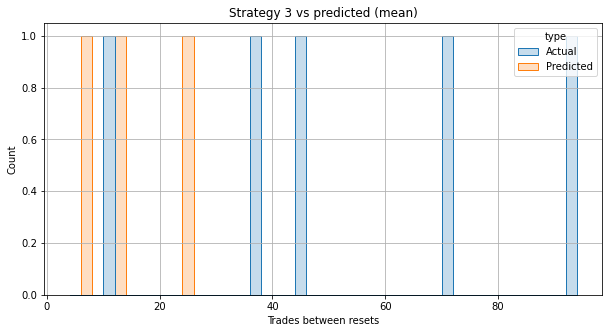

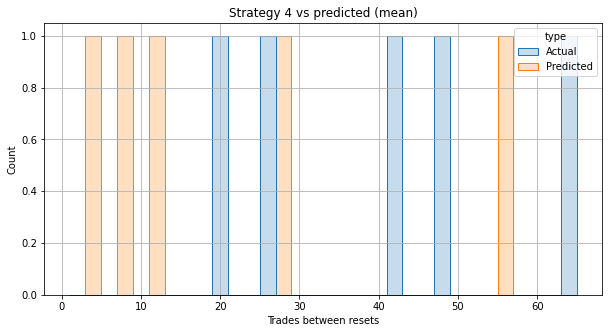

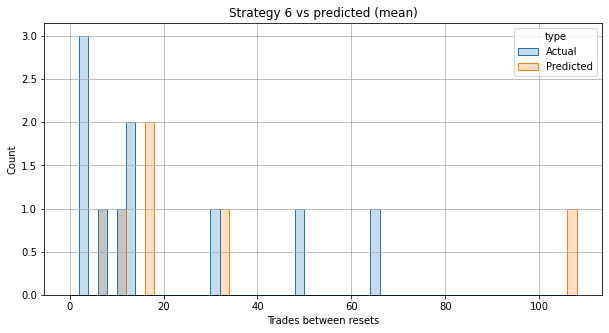

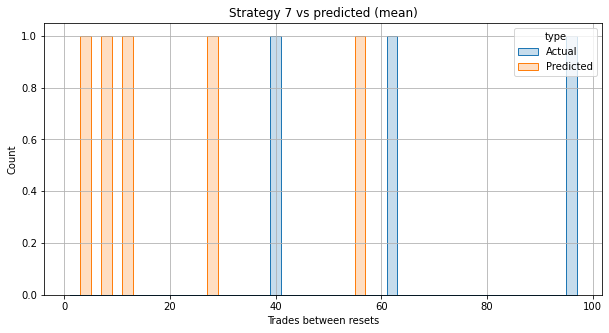

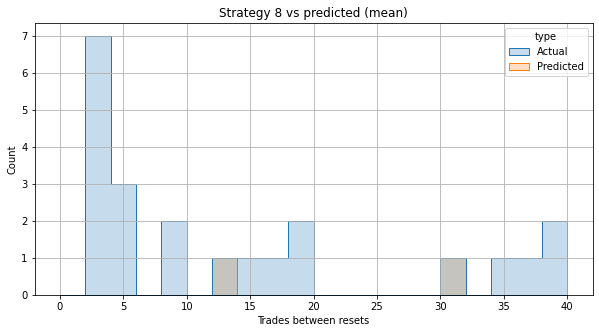

In [15]:
# Plot comparison of the actual vs predicted number of transactions between resets
max_trade_threshold = 1000000 # Optional filter for the maximum number or trades
                                # Useful to eliminate outliers in the plot for visual comparison
                                # Set at some large number if filtering is not required 

display(Markdown("**Histograms of strategy actual data vs predicted (by mean trade frequency) trade count between resets.**"))
# Change bin_width to change grouping in histogram
for index in range(len(strat_dfs)):
    plot_strat_predicted_trades_hist(index, strat_dfs[index], prediction_mean_dfs[index], 'mean', is_mod_reset=True)

**Histograms of strategy actual data vs predicted (by median trade frequency) trade count between resets.**

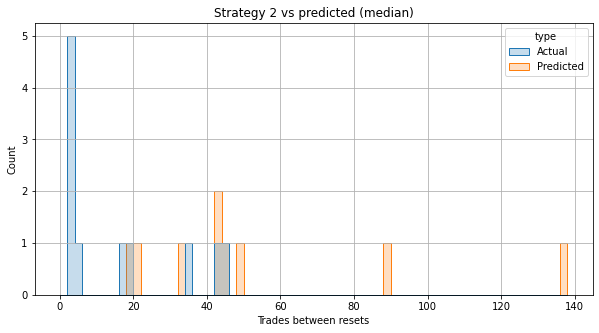

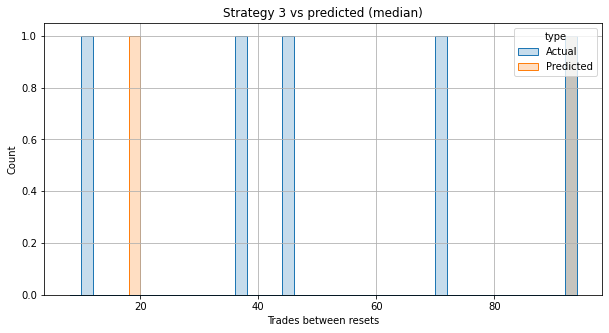

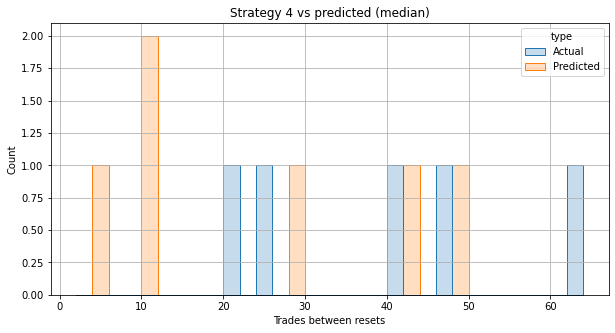

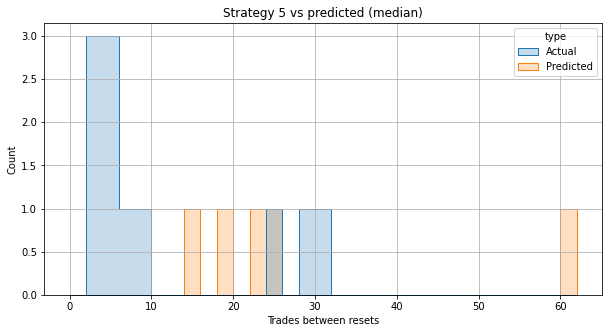

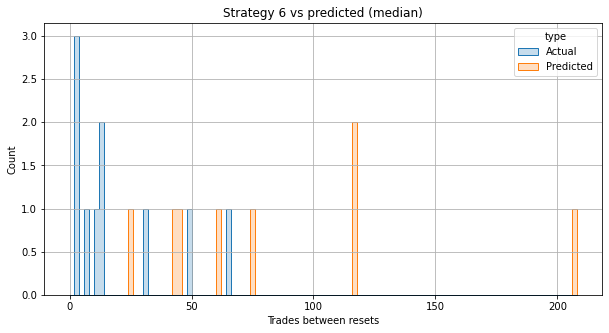

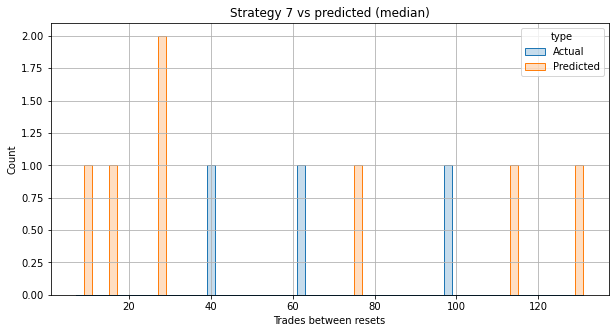

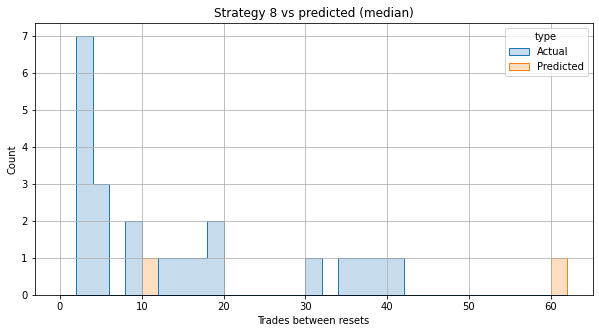

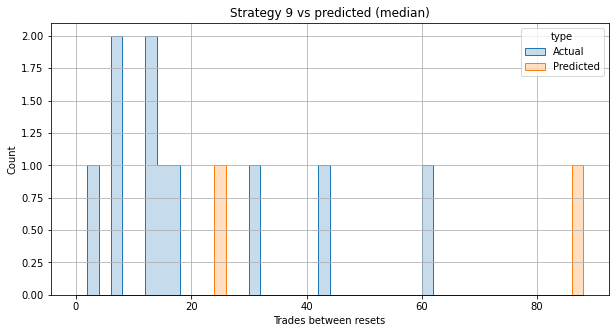

In [16]:
display(Markdown("**Histograms of strategy actual data vs predicted (by median trade frequency) trade count between resets.**"))
for index in range(len(strat_dfs)):
    if prediction_median_dfs[index] is not None:
        plot_strat_predicted_trades_hist(index, strat_dfs[index], prediction_median_dfs[index], 'median', is_mod_reset=True)        

<b> Generate comparison for trades between resets statistics. </b>
<br>All the comparisons are combined in a matrix. Where each column represents statistical metrics from either actiual strategy data named as <i>'strat_{strategy number here}'</i> or predicted data using mean or median time for model sheet choice named as <i>'pred_mean_{strategy number here}'</i> or <i>'pred_median_{strategy number here}'</i>

In [17]:
# Generate comparison for trades between resets statistics
stat_comparison_df = None
for index in range(len(strat_dfs)):
    curr_stat_comp = None
    if prediction_mean_dfs[index] is not None:
        curr_stat_comp = ev.compare_distributions(strat_dfs[index], prediction_mean_dfs[index], directions=[], is_mod_reset=True)
        curr_stat_comp.columns = ['strat_{}'.format(index+1), 'pred_mean_{}'.format(index+1)]
    if prediction_median_dfs[index] is not None:
        median_stat_comp = ev.compare_distributions(strat_dfs[index], prediction_median_dfs[index], directions=[], is_mod_reset=True)
        if curr_stat_comp is None:
            curr_stat_comp = median_stat_comp
            curr_stat_comp.columns = ['strat_{}'.format(index+1), 'pred_median_{}'.format(index+1)]
        else:
            curr_stat_comp['pred_median_{}'.format(index+1)] = median_stat_comp['Predicted'].values
    
    if curr_stat_comp is not None:
        if stat_comparison_df is None:
            stat_comparison_df = curr_stat_comp
        else:
            stat_comparison_df = pd.concat([stat_comparison_df, curr_stat_comp], axis=1)

display(Markdown("**Aggregated statistical comparison of actual data vs predicted trade count between resets.**"))
display(stat_comparison_df)

**Aggregated statistical comparison of actual data vs predicted trade count between resets.**

,strat_2,pred_median_2,strat_3,pred_mean_3,pred_median_3,strat_4,pred_mean_4,pred_median_4,strat_5,pred_median_5,...,pred_mean_6,pred_median_6,strat_7,pred_mean_7,pred_median_7,strat_8,pred_mean_8,pred_median_8,strat_9,pred_median_9
mean,16.090909,52.777778,51.200000,14.666667,55.500000,39.400000,21.400000,24.166667,10.818182,28.600000,...,31.666667,86.250000,66.000000,21.400000,57.285714,14.090909,22.000000,35.500000,20.200000,56.500000
median,5.000000,42.000000,45.000000,13.000000,55.500000,41.000000,12.000000,20.000000,4.000000,23.000000,...,16.500000,67.500000,62.000000,12.000000,28.000000,9.000000,22.000000,35.500000,13.000000,56.500000
std,17.207292,37.415831,31.924912,9.609024,53.033009,17.672012,21.489532,18.648503,11.250051,18.514859,...,37.987717,59.586072,29.206164,21.489532,49.724958,13.337770,12.727922,36.062446,18.552029,44.547727
cv,1.069380,0.708932,0.623533,0.655161,0.955550,0.448528,1.004184,0.771662,1.039921,0.647373,...,1.199612,0.690853,0.442518,1.004184,0.868017,0.946551,0.578542,1.015844,0.918417,0.788455
mad,3.000000,9.000000,26.000000,7.000000,37.500000,16.000000,9.000000,13.000000,2.000000,4.000000,...,8.000000,33.500000,23.000000,9.000000,19.000000,7.000000,9.000000,25.500000,6.500000,31.500000
min,2.000000,19.000000,10.000000,6.000000,18.000000,20.000000,3.000000,4.000000,2.000000,15.000000,...,7.000000,25.000000,39.000000,3.000000,9.000000,2.000000,13.000000,10.000000,2.000000,25.000000
max,45.000000,137.000000,93.000000,25.000000,93.000000,64.000000,56.000000,49.000000,31.000000,61.000000,...,107.000000,208.000000,97.000000,56.000000,131.000000,40.000000,31.000000,61.000000,60.000000,88.000000
iqr,24.000000,16.000000,34.000000,9.500000,37.500000,22.000000,20.000000,28.500000,13.000000,6.000000,...,17.500000,72.500000,29.000000,20.000000,73.500000,15.750000,9.000000,25.500000,18.250000,31.500000
skew,0.756337,1.416232,0.066668,0.309058,0.000000,0.255385,0.908134,0.262541,0.992528,1.338323,...,1.580047,1.055727,0.246887,0.908134,0.514081,0.841979,0.000000,0.000000,1.159830,0.000000
kurtosis,-1.076817,0.900702,-1.155875,-1.500000,-2.000000,-1.224267,-0.670438,-1.575712,-0.845244,0.047169,...,0.792163,0.140322,-1.500000,-0.670438,-1.406591,-0.761373,-2.000000,-2.000000,0.105962,-2.000000


Here cell values are for trades per reset. Rows are:
- <b>mean:</b> mean 
- <b>median:</b> median
- <b>std:</b> standard deviation
- <b>cv:</b> coefficient of variation <i>(std/mean)</i>
- <b>mad:</b> median absolute deviation <i>(median value of the difference between original data and its median)</i> 
- <b>min:</b> minimum
- <b>max:</b> maximum
- <b>iqr:</b> interquartile range <i>(spread of the middle 50% of data)</i>
- <b>skew:</b> skewness of data around the mean 
- <b>kurtosis:</b> dependence of variance on extreme outliers (tails)
- <b>95% CI lower:</b> lower boundary of 95% confidence interval
- <b>95% CI upper:</b> upper boundary of 95% confidence interval
- <b>Number of trades:</b> total number of transactions in the dataset
- <b>Number of resets:</b> total number of resets
- <b>% resets:</b> ratio of number of resets over total number of transactions recorded 

In case of excessive number of strategies compared the matrix view may be overcomplicated. In such case, the comparison for a specific strategy could be displayed separately.
<br><br>User needs to choose the 'strategy_num' to be the strategy that needs to be explored separately. <i>(e.g. strategy_num = 4)</i>
<br><b> By changing the 'strategy_num' value and executing this block user can view any strategy comparison.


In [19]:
display(Markdown("**Single strategy statistical comparison of actual data vs predicted trade count between resets.**"))
# Choose strategy number to change output
strategy_num = 4
display(stat_comparison_df[[col for col in stat_comparison_df.columns if str(strategy_num) in col]])

**Single strategy statistical comparison of actual data vs predicted trade count between resets.**

,strat_4,pred_mean_4,pred_median_4
mean,39.400000,21.400000,24.166667
median,41.000000,12.000000,20.000000
std,17.672012,21.489532,18.648503
cv,0.448528,1.004184,0.771662
mad,16.000000,9.000000,13.000000
min,20.000000,3.000000,4.000000
max,64.000000,56.000000,49.000000
iqr,22.000000,20.000000,28.500000
skew,0.255385,0.908134,0.262541
kurtosis,-1.224267,-0.670438,-1.575712


<b>Run hypothesis test for trades between resets of actual vs predicted data. 

In [22]:
# Generate hypothesis test for trades between resets statistics of actual vs predicted
# Evaluate given distributions using Welch’s t-test and Mann–Whitney U tests
# Important to note that t-test asumes data normality and compares means when variances are different
# Mann–Whitney U test compares medians and distribution shapes with no normality assumption

hypothesis_dfs = pd.DataFrame()
for index in range(len(strat_dfs)):
    actual = strat_dfs[index].loc[strat_dfs[index]['reset_mod'], 'trade_count_mod']
    # Mean-based hypothesis test
    if prediction_mean_dfs[index] is not None:
        predicted = prediction_mean_dfs[index].loc[prediction_mean_dfs[index]['reset'], 'trade_count']
        mean_test = evaluate_hypothesis_test(index, actual, predicted, label='mean', alpha=0.05)
        hypothesis_dfs = pd.concat([hypothesis_dfs, mean_test], axis=1)
    # Median-based hypothesis test
    if prediction_median_dfs[index] is not None:
        predicted = prediction_median_dfs[index].loc[prediction_median_dfs[index]['reset'], 'trade_count']
        median_test = evaluate_hypothesis_test(index, actual, predicted, label='median', alpha=0.05)
        hypothesis_dfs = pd.concat([hypothesis_dfs, median_test], axis=1)

display(Markdown("**If test is significant we reject the null hypothesis:**"))
print('t-test null hypothesis: equal means')
print('Mann–Whitney U test: equal ranks (similar distribution)')
display(hypothesis_dfs)

**If test is significant we reject the null hypothesis:**

t-test null hypothesis: equal means
Mann–Whitney U test: equal ranks (similar distribution)


,strat_2(median),strat_3(mean),strat_3(median),strat_4(mean),strat_4(median),strat_5(median),strat_6(mean),strat_6(median),strat_7(mean),strat_7(median),strat_8(mean),strat_8(median),strat_9(median)
t-test p-value,0.020452,0.062086,0.928748,0.187388,0.199205,0.099433,0.48196,0.015195,0.096344,0.740676,0.535415,0.554546,0.45058
t-test significant,True,False,False,False,False,False,False,True,False,False,False,False,False
Mann–Whitney U p-value,0.008588,0.142857,1.0,0.222222,0.329004,0.077771,0.301387,0.00506,0.071429,0.647506,0.40165,0.228074,0.161851
Mann–Whitney U significant,True,False,False,False,False,False,False,True,False,False,False,False,False


If the t-test is statistically significant, one rejects the null hypothesis, meaning the means of these two distributions are not statistically the same.
<br> If Mann–Whitney U test showed statistical significance to reject similarity in ranks, it implies samples are from different distributions.
<br><b><i>If small number of entries are used to compare distributions, the probability of incorrect reasoning of the test outcome increases.</i>

<br><br><br>When the number of resets detected in actual data is similar to that of predicted data it is reasonable to compare error between predicted and actual number of trades between resets. 
<br><br>Actual and predicted number of trades between resets are sorted in ascending order before the comparison. 
<br>User can choose 'reset_count_tolerance' value to be any positive number that indicates the difference in number of actual and predicted resets that could be tolerated if these numbers do not match. <i>(e.g. actual number of resets is 6 while predicted number of resets is 5. It could still be reasonable to compare the errors, then setting <b>reset_count_tolerance=1</b>, which is the difference beteween reset numbers will ensure the script compares the matching part of actual vs predicted resets. In this example that will be the first 5 resets.)</i>
<br><br>The output shows: 
- Mean absolute error (MAE)
- Root mean square error (RMSE)
- Mean absolute percentage error (MAPE)

<br> User can choose <b>'plot_trade_count'</b> and <b>'plot_error_dist'</b> to be either True or False, indicating whether to plot predicted trade count between resets vs actual and plot error distribution histogram, respectively <i>(e.g. plot_trade_count = True and plot_error_dist=True to show both plots).</i>  

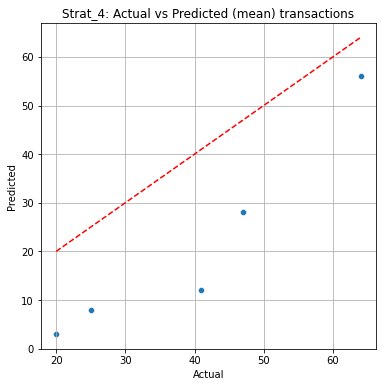

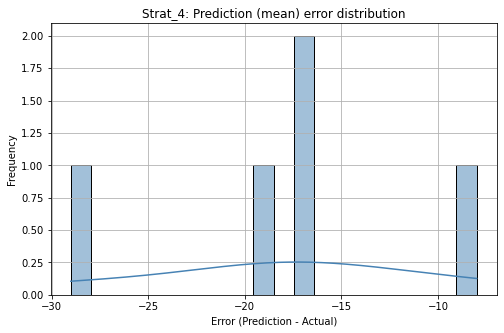

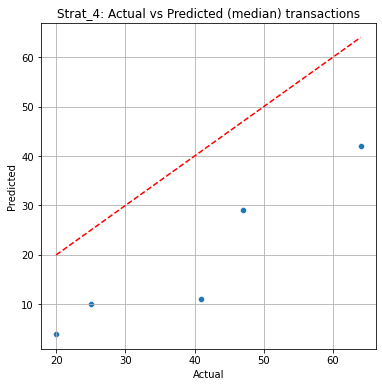

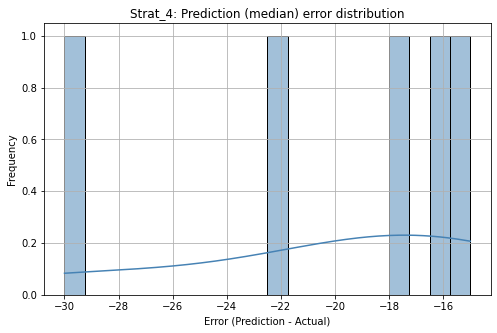

,strat_4(mean),strat_4(median)
MAE,18.000000,20.200000
RMSE,19.204166,20.923671
MAPE,55.331448,57.168721


In [20]:
reset_count_tolerance = 1
plot_trade_count = True
plot_error_dist = True

prediction_error_dfs = pd.DataFrame()

for index in range(len(strat_dfs)):
    actual_df = strat_dfs[index]
    # Mean-based prediction
    if prediction_mean_dfs[index] is not None:
        mean_error = evaluate_prediction_error(
            index, actual_df, prediction_mean_dfs[index], label='mean',
            reset_count_tolerance=reset_count_tolerance,
            plot_trade_count=plot_trade_count, plot_error_dist=plot_error_dist,
            is_mod_reset=True
        )
        if mean_error is not None:
            prediction_error_dfs = pd.concat([prediction_error_dfs, mean_error], axis=1)
    # Median-based prediction
    if prediction_median_dfs[index] is not None:
        median_error = evaluate_prediction_error(
            index, actual_df, prediction_median_dfs[index], label='median',
            reset_count_tolerance=reset_count_tolerance,
            plot_trade_count=plot_trade_count, plot_error_dist=plot_error_dist,
            is_mod_reset=True
        )
        if median_error is not None:
            prediction_error_dfs = pd.concat([prediction_error_dfs, median_error], axis=1)

display(prediction_error_dfs)

The above is the comparison of various error metrics between actual data and predictions. It is important to choose proper alignment between actual and predicted transaction counts. Currently, the actual and predicted values are ordered based on the transaction count (from low to high). 